## ADS1115 Analog to Digitial Converter  

The ADS1115 is a 16 bit resolution analog to digitial converter.

Manufacturer Link: www.ti.com/product/ADS1115  

Breakout Board Used: https://www.adafruit.com/product/1085

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from meerkat import base, ads, parser

In [2]:
dev = ads.ADS1115(bus_n=1)

#### Configuration

In [3]:
dev.pga('6.144')  # Other options: '6.144', '4.096'
dev.mux('1G')     # pin 0 relative to ground

In [4]:
dev.print_attributes()

ADS11x5 Configuration Attributes
--------------------------------
Config Register: 53635 0xd183 0b1101000110000011
PGA Range: +/- 6.144 Volts
Mode: single
Data Rate: 128 SPS
Input Multiplexer: 1G
Comparator:
 Queue: off
 Latching: off
 Polarity: Active 1
 Mode: trad


#### Measurements  
For this demo, a 2.048 V reference is connected to A1

In [5]:
print('Measured voltage: {}'.format(dev.voltage()))

Measured voltage: 0.5818125000000001


In [6]:
dev.get(description='test_1', n=5)

[['test_1', 1, '1G', 0.5829375],
 ['test_1', 2, '1G', 0.58875],
 ['test_1', 3, '1G', 0.58725],
 ['test_1', 4, '1G', 0.5874375000000001],
 ['test_1', 5, '1G', 0.5881875]]

#### JSON Data Publishing

In [7]:
# lower metadata interval from a default of once every 10 samples
dev.json_writer.metadata_interval = 3

In [8]:
# writing method with description and sample number
dev.publish(description='test_2', n=5)

['{"description": "test_2", "sample_n": 0, "mux": "1G", "voltage": 0.5818125000000001, "std_time_ms": "2020-02-16 20:50:43.465479"}',
 '{"description": "test_2", "sample_n": 1, "mux": "1G", "voltage": 0.5895, "std_time_ms": "2020-02-16 20:50:43.476787"}',
 '{"description": null, "sample_n": 2, "mux": "1G", "voltage": 0.5885625, "std_time_ms": "2020-02-16 20:50:43.488847", "name": "ADS1115", "title": null, "format": null, "encoding": "utf-8", "bytes": null, "hash": null, "schema": null, "sources": null, "licenses": null, "line_terminator": "\\n", "quote_char": "\\"", "double_quote": true, "escape_char": "\\\\", "null_sequence": "NA", "comment": "#", "skip_lines": 0, "path": null, "device": {"name": "ADS1115", "version_hw": "1.0", "version_sw": "1.0", "accuracy": null, "precision": "16bit", "bus": "<meerkat.i2c_pi.WrapI2C object at 0xacfd09b0>", "state": null, "active": null, "error": null, "dtype": null, "description": "Texas Instruments 16-bit 860SPS 4-Ch Delta-Sigma ADC with PGA", "ur

#### JSON Writer Output

In [9]:
# default writer format is CSV, switch to JSON
dev.writer_output = 'json'

In [10]:
# writer method with description and sample number
dev.write(description='test_3', n=30)

In [11]:
dev.json_writer.path

'2020_02_16_20_50_45.jsontxt'

In [12]:
with open(dev.json_writer.path, 'r') as f:
    for _ in range(4):
        print(f.readline().strip())

{"description": "test_3", "sample_n": 0, "mux": "1G", "voltage": 0.583875, "std_time_ms": "2020-02-16 20:50:45.055303"}
{"description": "test_3", "sample_n": 1, "mux": "1G", "voltage": 0.58875, "std_time_ms": "2020-02-16 20:50:45.074609"}
{"description": null, "sample_n": 2, "mux": "1G", "voltage": 0.58725, "std_time_ms": "2020-02-16 20:50:45.093516", "name": "ADS1115", "title": null, "format": null, "encoding": "utf-8", "bytes": null, "hash": null, "schema": null, "sources": null, "licenses": null, "line_terminator": "\n", "quote_char": "\"", "double_quote": true, "escape_char": "\\", "null_sequence": "NA", "comment": "#", "skip_lines": 0, "path": "2020_02_16_20_50_45.jsontxt", "device": {"name": "ADS1115", "version_hw": "1.0", "version_sw": "1.0", "accuracy": null, "precision": "16bit", "bus": "<meerkat.i2c_pi.WrapI2C object at 0xacfd09b0>", "state": null, "active": null, "error": null, "dtype": null, "description": "Texas Instruments 16-bit 860SPS 4-Ch Delta-Sigma ADC with PGA", "ur

#### CSV Writer Output

In [13]:
# switch back to CSV format
dev.writer_output = 'csv'

In [14]:
dev.write(description='test_4', n=15)

In [15]:
m, df = parser.csv_resource(dev.csv_writer.path)

In [16]:
df.head()

,std_time_ms,description,sample_n,mux,voltage,datetime64_ns
0,2020-02-16 20:50:45.657897,test_4,0,1G,0.581625,2020-02-16 20:50:45.657897
1,2020-02-16 20:50:45.670304,test_4,1,1G,0.588000,2020-02-16 20:50:45.670304
2,2020-02-16 20:50:45.687586,test_4,2,1G,0.588187,2020-02-16 20:50:45.687586
3,2020-02-16 20:50:45.700114,test_4,3,1G,0.588938,2020-02-16 20:50:45.700114
4,2020-02-16 20:50:45.712750,test_4,4,1G,0.589500,2020-02-16 20:50:45.712750


In [17]:
df['rolling_mean'] = df.voltage.rolling(4, win_type='triang').mean()

In [18]:
df_mean = df.voltage.mean()
df['mean'] = df_mean

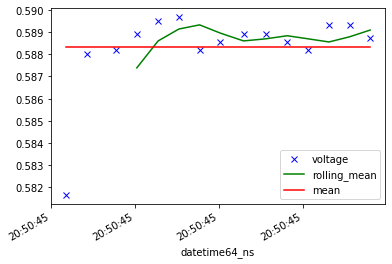

In [19]:
df.datetime64_ns = df.datetime64_ns.dt.tz_localize('UTC')  # Pandas 0.24.1 hack
df[['datetime64_ns', 'voltage',
    'rolling_mean', 'mean']].plot(x='datetime64_ns',
                                  style=[' xb', '-g', '-r']);

In [20]:
print('Mean: {:8.6} Volts DC'.format(df_mean))
print('Standard Deviation: {}'.format(df.voltage.std()))

Mean: 0.588313 Volts DC
Standard Deviation: 0.0019208675495351324


In [21]:
dt = df.datetime64_ns[len(df)-1]-df.datetime64_ns[0]
dtt = dt.seconds + dt.microseconds / 10**6
print('Sample Rate: {:.4f} Hz'.format(len(df)/dtt))

Sample Rate: 82.9164 Hz


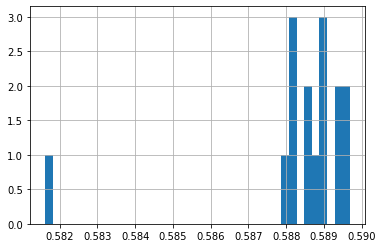

In [22]:
df.voltage.hist(bins=40);